# Convert hybrid to height in meters
this is a script converting the hybrid layer into meters at a given location

<xarray.DataArray ()>
array(1.28432417)
Coordinates:
    time       datetime64[ns] 2022-01-01
    height0    float32 0.0
    hybrid     float64 0.9985
    x          float32 1.644e+06
    y          float32 -1.779e+05
    longitude  float64 ...
    latitude   float64 ...


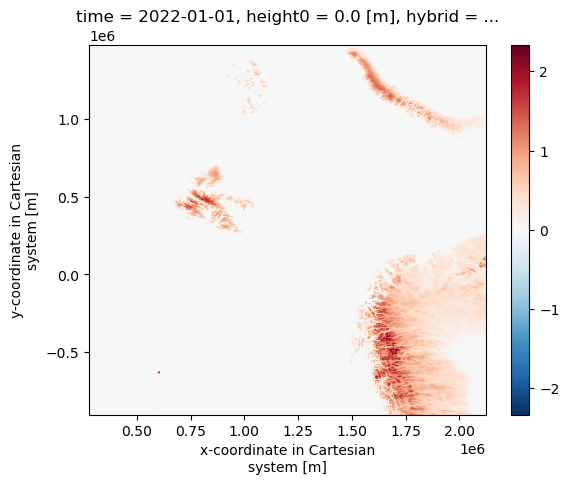

In [2]:
import xarray
import numpy as np

import netCDF4 as nc
import matplotlib.pylab as plt

import pyproj



opendap_url = "https://thredds.met.no/thredds/dodsC/aromearcticarchive/"+\
           "2022/01/01/arome_arctic_full_2_5km_20220101T00Z.nc"

#Ask for time=0 to make the calculation smaller, height0=0 to remove the 4th dimension
ds = xarray.open_dataset(opendap_url).isel(time=0,height0=0)

# Formula to calculate pressure from hybrid: p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)"
ap = ds.ap
b = ds.b
surface_pressure = ds.surface_air_pressure

### test

surface_geo = ds.surface_geopotential


# Note that k = 0 is top of atmosphere (ToA), and k = 64 is surface
pressure_at_k = (ap + (b*surface_pressure))
temperature_at_k = ds.air_temperature_ml
R = 287.058
g = 9.81

height_at_k = xarray.full_like(pressure_at_k, fill_value=0)

max_k = len(height_at_k.hybrid) -1
# Compute the height of the lowest model level
height_at_k.values[max_k,:,:] = surface_geo/g
height_at_k.values[max_k,:,:] *= np.log(surface_pressure / (pressure_at_k.isel(hybrid = max_k)))

# Loop over the rest of the model levels
for hybrid in range(max_k - 1,-1,-1):
    height_at_k.values[hybrid,:,:] = (R*temperature_at_k.isel(hybrid=hybrid))/g  
    height_at_k.values[hybrid,:,:] *= np.log((pressure_at_k.isel(hybrid = hybrid + 1)) / \
                                             (pressure_at_k.isel(hybrid = hybrid)))
    height_at_k.values[hybrid,:,:] += height_at_k.isel(hybrid=hybrid + 1)
    



# Projecting lat lon to x, y

ncfile = nc.Dataset(opendap_url)

crs_AA = pyproj.CRS.from_cf(
         {
            "grid_mapping_name": "lambert_conformal_conic",
            "standard_parallel": [77.5, 77.5],
            "longitude_of_central_meridian": -25.0,
            "latitude_of_projection_origin": 77.5,
             "earth_radius": 6371000.0,
         }
)

# Transformer to project from ESPG:4368 (WGS:84) to our lambert_conformal_conic
proj = pyproj.Transformer.from_crs(4326,crs_AA,always_xy=True)
# Compute projected coordinates of lat/lon point
lat = 69.67
lon = 22.06
X,Y = proj.transform(lon,lat)

# Find nearest neighbour
x = ncfile.variables["x"][:]
y = ncfile.variables["y"][:]

Ix = np.argmin(np.abs(x - X))
Iy = np.argmin(np.abs(y - Y))


#trekker ut høyde i punktet
H = height_at_k[:,Iy,Ix]

print(H[64])

#####

# finds surface height in the model at location
h2 = ncfile.variables["surface_geopotential"][0,:,:,:]

h2_i_kord = h2[:,Iy,Ix]

høyde = h2_i_kord/9.81 #gir høyde i akk dette punktet! = 866,93moh

# total height m.a.s.l
H1 = H + høyde # H1 kan brukes til å plotte høyde sammen med andre variabler


######
# model height at lowest level
 
height_at_k.isel(hybrid=64).plot()